In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

In [2]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")

In [3]:
df_test["trip_duration"] = -1

In [4]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N,-1
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N,-1
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N,-1
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N,-1
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N,-1


In [5]:
full_df = pd.concat([df_train, df_test], axis=0)

In [6]:
import haversine
def haversine_distance(x):
    a_lat, a_lon, b_lat, b_lon = x
    return haversine.haversine((a_lat, a_lon), (b_lat, b_lon), unit="km")

In [7]:
import multiprocess
# Multithreaded apply function for a dataframe. This uses multiprocessing to map a function to a series, vastly speeding up feature generation

N_THREADS = 8
def apply_multithreaded(data, func):
    pool = multiprocess.Pool(N_THREADS)  # Spawn a pool of processes
    data = data.values  # Retrieve a numpy array which can be iterated over

    result = pool.map(func, data)  # Map the function over the data multi-threaded
    pool.close()  # Close the threads
    return result

In [8]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [9]:
full_df["store_and_fwd_flag"] = full_df["store_and_fwd_flag"].apply(lambda x: 1 if x == "Y" else 0)

In [10]:
full_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag      int64
trip_duration           int64
dtype: object

In [11]:
full_df["pickup_datetime"] = pd.to_datetime(full_df["pickup_datetime"])
full_df["dropoff_datetime"] = pd.to_datetime(full_df["dropoff_datetime"])

In [13]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435


In [14]:
full_df["day_of_week"] = [t.dayofweek for t in full_df["pickup_datetime"]]

### Create Distance Features

In [15]:
# Map the three distance functions over all samples in the training set
full_df["dist_l1"] = np.abs(full_df["pickup_latitude"] - full_df["dropoff_latitude"]) + np.abs(full_df["pickup_longitude"] - full_df["dropoff_longitude"])
full_df["dist_l2"] = np.sqrt((full_df["pickup_latitude"] - full_df["dropoff_latitude"]) ** 2 + (full_df["pickup_longitude"] - full_df['dropoff_longitude']) ** 2)
# As haversine is not vectorised, we use the multithreading approach for speed
full_df["dist_haversine"] = apply_multithreaded(full_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']], haversine_distance)

In [16]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_week,dist_l1,dist_l2,dist_haversine
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,0,0.020,0.018,1.499
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,6,0.026,0.020,1.806
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1,0.080,0.060,6.385
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,2,0.015,0.013,1.486
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,5,0.011,0.011,1.189


### Create Direction of Travel Features

In [17]:
full_df["delta_lat"] = full_df["dropoff_latitude"] - full_df["pickup_latitude"]
full_df["delta_long"] = full_df["dropoff_longitude"] - full_df["pickup_longitude"]
full_df["angle"] = (180 / np.pi) * np.arctan2(full_df["delta_lat"], full_df["delta_long"]) + 180

In [18]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_week,dist_l1,dist_l2,dist_haversine,delta_lat,delta_long,angle
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,0,0.020,0.018,1.499,-0.002,0.018,172.412
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,6,0.026,0.020,1.806,-0.007,-0.019,21.244
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1,0.080,0.060,6.385,-0.054,-0.026,63.965
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,2,0.015,0.013,1.486,-0.013,-0.002,80.457
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,5,0.011,0.011,1.189,-0.011,0.000,90.695


### Creating Traffic Features

In [19]:
full_df['day'] = full_df['pickup_datetime'].dt.date
full_df['hour'] = full_df['pickup_datetime'].dt.hour

In [20]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_week,dist_l1,dist_l2,dist_haversine,delta_lat,delta_long,angle,day,hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,0,0.020,0.018,1.499,-0.002,0.018,172.412,2016-03-14,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,6,0.026,0.020,1.806,-0.007,-0.019,21.244,2016-06-12,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1,0.080,0.060,6.385,-0.054,-0.026,63.965,2016-01-19,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,2,0.015,0.013,1.486,-0.013,-0.002,80.457,2016-04-06,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,5,0.011,0.011,1.189,-0.011,0.000,90.695,2016-03-26,13


In [21]:
daily_traffic = full_df.groupby('day')['day'].count()  # Count the number of trips on each day
hourly_traffic = full_df.groupby('hour')['hour'].count()  # Count the number of trips in each hour

In [22]:
# Loop over the data and lookup the count information on the corresponding day to fill the feature
full_df['daily_count'] = full_df['day'].apply(lambda day: daily_traffic[day])
full_df['hourly_count'] = full_df['hour'].apply(lambda hour: hourly_traffic[hour])

In [23]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_week,dist_l1,dist_l2,dist_haversine,delta_lat,delta_long,angle,day,hour,daily_count,hourly_count
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,0,0.020,0.018,1.499,-0.002,0.018,172.412,2016-03-14,17,11564,109399
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,6,0.026,0.020,1.806,-0.007,-0.019,21.244,2016-06-12,0,10086,75962
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1,0.080,0.060,6.385,-0.054,-0.026,63.965,2016-01-19,11,11315,97621
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,2,0.015,0.013,1.486,-0.013,-0.002,80.457,2016-04-06,19,12045,128745
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,5,0.011,0.011,1.189,-0.011,0.000,90.695,2016-03-26,13,12132,101997


### Creating Time Estimate Features

In [36]:
full_df['haversine_speed'] = full_df['dist_haversine'] / full_df['trip_duration']  # Calculate haversine speed for training set
full_df['haversine_speed_km/h'] = full_df['dist_haversine'] / (full_df['trip_duration'] / 3600)
hourly_speed = full_df.groupby('hour')['haversine_speed'].mean()  # Find average haversine_speed for each hour in the training set
hourly_speed_fill = full_df['haversine_speed'].mean()  # Get mean across whole dataset for filling unknowns

# Create feature
full_df_hourly_speed = full_df['hour'].apply(lambda hour: hourly_speed[hour] if hour in hourly_speed else hourly_speed_fill)
full_df['haversine_speed_estim'] = full_df['dist_haversine'] / full_df_hourly_speed

### Feature Inspection

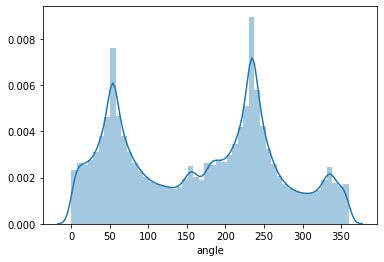

In [26]:
import seaborn as sns

sns.distplot(full_df["angle"])

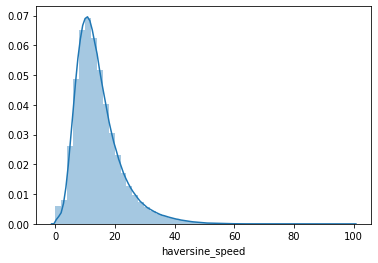

In [27]:
sns.distplot(full_df[(full_df["trip_duration"] != -1) & (full_df["haversine_speed"] < 100)]["haversine_speed"])

In [28]:
len(full_df[(full_df["trip_duration"] != -1) & (full_df["haversine_speed"] > 100)])

175

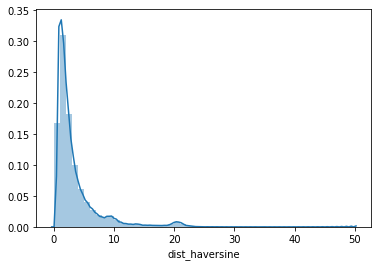

In [29]:
sns.distplot(full_df[full_df["dist_haversine"] < 50]["dist_haversine"])

In [30]:
len(full_df[(full_df["trip_duration"] != -1) & (full_df["dist_haversine"] > 50)])

88

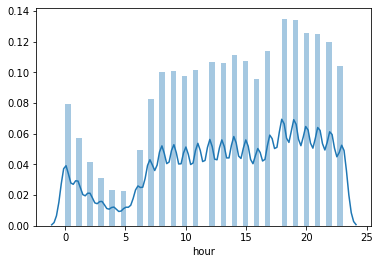

In [31]:
sns.distplot(full_df["hour"])

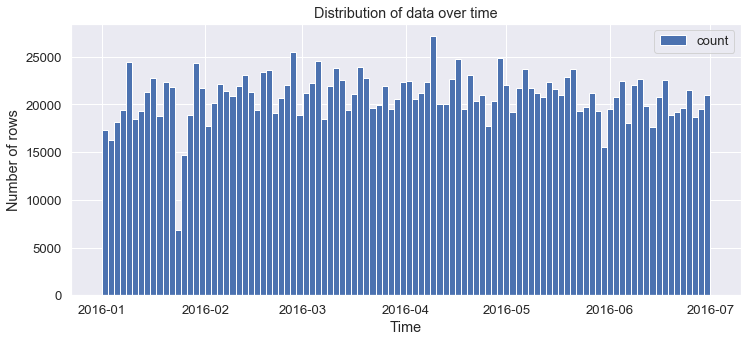

In [32]:
import matplotlib.pyplot as plt

# Plot distribution of the dataset
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 5))
plt.hist([x.to_pydatetime() for x in full_df['pickup_datetime']], bins=100, label='count')
plt.title('Distribution of data over time')
plt.xlabel('Time')
plt.ylabel('Number of rows')
plt.legend()
plt.show()

### Train Test Split

In [37]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_week,dist_l1,dist_l2,dist_haversine,delta_lat,delta_long,angle,day,hour,daily_count,hourly_count,haversine_speed_km/s,haversine_speed,haversine_speed_estim,haversine_speed_km/h
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,0,0.020,0.018,1.499,-0.002,0.018,172.412,2016-03-14,17,11564,109399,11.856,0.003,-1.509,11.856
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,6,0.026,0.020,1.806,-0.007,-0.019,21.244,2016-06-12,0,10086,75962,9.804,0.003,-1.514,9.804
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1,0.080,0.060,6.385,-0.054,-0.026,63.965,2016-01-19,11,11315,97621,10.822,0.003,-7.044,10.822
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,2,0.015,0.013,1.486,-0.013,-0.002,80.457,2016-04-06,19,12045,128745,12.466,0.003,-1.586,12.466
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,5,0.011,0.011,1.189,-0.011,0.000,90.695,2016-03-26,13,12132,101997,9.837,0.003,-1.206,9.837


In [38]:
# split to new_train and new_test
train_len = len(df_train)
new_train = full_df.iloc[:train_len, :]
new_test = full_df.iloc[train_len:, :]

In [39]:
# dropping columns for both train and test
new_train.drop(["id","pickup_datetime","dropoff_datetime","day","haversine_speed_km/s"], axis=1, inplace=True)
new_test.drop(["pickup_datetime","dropoff_datetime","day","trip_duration","haversine_speed_km/s"], axis=1, inplace=True)

/Users/advanceai/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [40]:
new_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_week,dist_l1,dist_l2,dist_haversine,delta_lat,delta_long,angle,hour,daily_count,hourly_count,haversine_speed,haversine_speed_estim,haversine_speed_km/h
0,2,1,-73.982,40.768,-73.965,40.766,0,455,0,0.020,0.018,1.499,-0.002,0.018,172.412,17,11564,109399,0.003,-1.509,11.856
1,1,1,-73.980,40.739,-73.999,40.731,0,663,6,0.026,0.020,1.806,-0.007,-0.019,21.244,0,10086,75962,0.003,-1.514,9.804
2,2,1,-73.979,40.764,-74.005,40.710,0,2124,1,0.080,0.060,6.385,-0.054,-0.026,63.965,11,11315,97621,0.003,-7.044,10.822
3,2,1,-74.010,40.720,-74.012,40.707,0,429,2,0.015,0.013,1.486,-0.013,-0.002,80.457,19,12045,128745,0.003,-1.586,12.466
4,2,1,-73.973,40.793,-73.973,40.783,0,435,5,0.011,0.011,1.189,-0.011,0.000,90.695,13,12132,101997,0.003,-1.206,9.837


In [46]:
new_test.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day_of_week,dist_l1,dist_l2,dist_haversine,delta_lat,delta_long,angle,hour,daily_count,hourly_count,haversine_speed,haversine_speed_estim,haversine_speed_km/h
0,id3004672,1,1,-73.988,40.732,-73.990,40.757,0,3,0.027,0.025,2.746,0.025,-0.002,274.742,23,10858,99656,-2.746,-2.323,-9887.147
1,id3505355,1,1,-73.964,40.680,-73.960,40.655,0,3,0.029,0.025,2.759,-0.025,0.004,100.133,23,10858,99656,-2.759,-2.334,-9933.274
2,id1217141,1,1,-73.997,40.738,-73.986,40.730,0,3,0.019,0.014,1.306,-0.008,0.011,144.442,23,10858,99656,-1.306,-1.105,-4702.166
3,id2150126,2,1,-73.956,40.772,-73.986,40.730,0,3,0.072,0.051,5.269,-0.041,-0.030,53.769,23,10858,99656,-5.269,-4.456,-18968.742
4,id1598245,1,1,-73.970,40.761,-73.962,40.756,0,3,0.014,0.010,0.961,-0.006,0.009,147.318,23,10858,99656,-0.961,-0.813,-3459.035


In [41]:
y = new_train["trip_duration"].copy()
x = new_train.drop("trip_duration", axis=1)

In [47]:
x_test = new_test.drop("id", axis=1)

In [43]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=1337)

In [48]:
import xgboost as xgb

# Convert our data into XGBoost's fast C++ format
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(x_test)

In [49]:
d_train